<a href="https://colab.research.google.com/github/packtpublishing/Machine-Learning-for-Imbalanced-Data/blob/main/chapter09/Class_Rectification_Loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
# Uncomment the following 2 lines if running this notebook for the first time
# install torchvision
# ! python3 -m pip install torchvision==0.13.0

In [2]:
# download MNIST (csv files) it contains images and labels in the same file (60000 for training, 10000 for testing)
!wget https://pjreddie.com/media/files/mnist_train.csv
!wget https://pjreddie.com/media/files/mnist_test.csv

--2023-02-06 06:05:39--  https://pjreddie.com/media/files/mnist_train.csv
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109575994 (104M) [application/octet-stream]
Saving to: ‘mnist_train.csv’

mnist_train.csv     100%[===================>] 104.50M  19.9MB/s    in 5.9s    

2023-02-06 06:05:46 (17.6 MB/s) - ‘mnist_train.csv’ saved [109575994/109575994]

--2023-02-06 06:05:46--  https://pjreddie.com/media/files/mnist_test.csv
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18289443 (17M) [application/octet-stream]
Saving to: ‘mnist_test.csv’

mnist_test.csv      100%[===================>]  17.44M  11.1MB/s    in 1.6s    

2023-02-06 06:05:48 (11.1 MB/s) - ‘mnist_test.csv’ saved [18289443/18289443]



In [3]:
# import libraries
import pandas as pd
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import random
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as sm
torch.manual_seed(0)
np.random.seed(0)

from collections import Counter 

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = torch.nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = torch.nn.Dropout2d()
        self.fc1 = torch.nn.Linear(320, 50)
        self.fc2 = torch.nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

    

In [4]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [5]:
def create_imbalanced(train_dataset, label_to_del, size):
  label_ids = [i for i, label in enumerate(train_dataset.y)
              if label == label_to_del]
  label_ids = np.random.choice(label_ids, size=size, replace=False)
  num_classes = 10
  classe_labels = range(num_classes)
  sample_probs = torch.rand(num_classes)

  idx_to_del = [i for i, label in enumerate(train_dataset.y) 
                if random.random() > sample_probs[label]]
  # remove more instances of 9
  idx_to_del += list(label_ids)
  imbalanced_train_dataset = copy.deepcopy(train_dataset)
  imbalanced_train_dataset.y = np.delete(train_dataset.y, idx_to_del, axis=0)
  imbalanced_train_dataset.X = np.delete(train_dataset.X, idx_to_del, axis=0)
  return imbalanced_train_dataset

In [6]:
# read the data
df_train = pd.read_csv('mnist_train.csv')
df_test = pd.read_csv('mnist_test.csv')

# get the image pixel values and labels (separate the images from labels)
train_labels = df_train.iloc[:, 0]
train_images = df_train.iloc[:, 1:]
test_labels = df_test.iloc[:, 0]
test_images = df_test.iloc[:, 1:]

#Transform to convert images to tensors
transform = transforms.Compose(
    [transforms.ToPILImage(),
     transforms.ToTensor(),
     transforms.Normalize((0.1302,), (0.3069,))
])

# custom dataset (it returns data(images+labes), indx(index of the image in the dataset))
class MNISTDataset(Dataset):
    def __init__(self, images, labels=None, transforms=None):
        self.X = images
        self.y = labels
        self.transforms = transforms
         
    def __len__(self):
        return (len(self.X))
    
    def __getitem__(self, indx):
        data = self.X[indx]
        data = np.asarray(data).astype(np.uint8).reshape(28, 28, 1)
        
        if self.transforms:
            data = self.transforms(data)
            
        if self.y is not None:
            return (data, self.y[indx]), indx
        else:
            return data, indx

imbalanced = True
label_to_del = 9
size= 3000

# create dataset objects
trainset = MNISTDataset(train_images.values, train_labels.values, transform)
testset = MNISTDataset(test_images.values, test_labels.values, transform)

if imbalanced:
  trainset = create_imbalanced(train_dataset=trainset, label_to_del=label_to_del, size = size)
test_dataloader = torch.utils.data.DataLoader(dataset=testset, batch_size=100)

In [7]:
trainset.y

array([0, 4, 1, ..., 1, 8, 6])

Distribution of classes in imbalanced dataset:


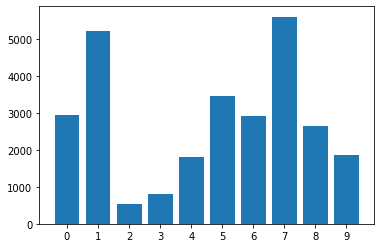

Counter({0: 2930,
         4: 1794,
         1: 5227,
         6: 2917,
         7: 5600,
         9: 1857,
         8: 2653,
         5: 3446,
         2: 533,
         3: 799})

In [8]:
print('Distribution of classes in imbalanced dataset:')
fig, ax = plt.subplots()
_, counts = np.unique(trainset.y, return_counts=True)
classe_labels = range(10)
ax.bar(classe_labels, counts)
ax.set_xticks(classe_labels)
plt.show()

from collections import Counter
Counter(trainset.y)

# From the above plot, the most imbalanced classes are 2, 3 and 9

Assumption: Although we implement this technique for just binary classes, it should be extensible to more than 2 classes as well. 

In [9]:
def vis(test_accs, confusion_mtxes, labels, figsize=(20, 8)):
    cm = confusion_mtxes[np.argmax(test_accs)]
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%' % p
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    
    fig = plt.figure(figsize=figsize)
    plt.subplot(1, 2, 1)
    plt.plot(test_accs, 'g')
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    sns.heatmap(cm, annot=annot, fmt='', cmap="Blues")
    plt.show()

# Baseline using Cross Entropy Loss

epoch: 0 [0/217 (0%)]	 training loss: 2.304643
epoch: 0 [100/217 (46%)]	 training loss: 1.181969
epoch: 0 [200/217 (92%)]	 training loss: 0.707810
Best test acc = 78.45%

Test dataset: Overall Loss: 0.6609, Overall Accuracy: 7844/9999 (78%)

epoch: 1 [0/217 (0%)]	 training loss: 0.706671
epoch: 1 [100/217 (46%)]	 training loss: 0.669879
epoch: 1 [200/217 (92%)]	 training loss: 0.428477
Best test acc = 88.73%

Test dataset: Overall Loss: 0.3854, Overall Accuracy: 8872/9999 (89%)

epoch: 2 [0/217 (0%)]	 training loss: 0.435678
epoch: 2 [100/217 (46%)]	 training loss: 0.554938
epoch: 2 [200/217 (92%)]	 training loss: 0.348692
Best test acc = 91.63%

Test dataset: Overall Loss: 0.2889, Overall Accuracy: 9162/9999 (92%)

epoch: 3 [0/217 (0%)]	 training loss: 0.327075
epoch: 3 [100/217 (46%)]	 training loss: 0.439488
epoch: 3 [200/217 (92%)]	 training loss: 0.337456
Best test acc = 93.15%

Test dataset: Overall Loss: 0.2464, Overall Accuracy: 9314/9999 (93%)

epoch: 4 [0/217 (0%)]	 training 

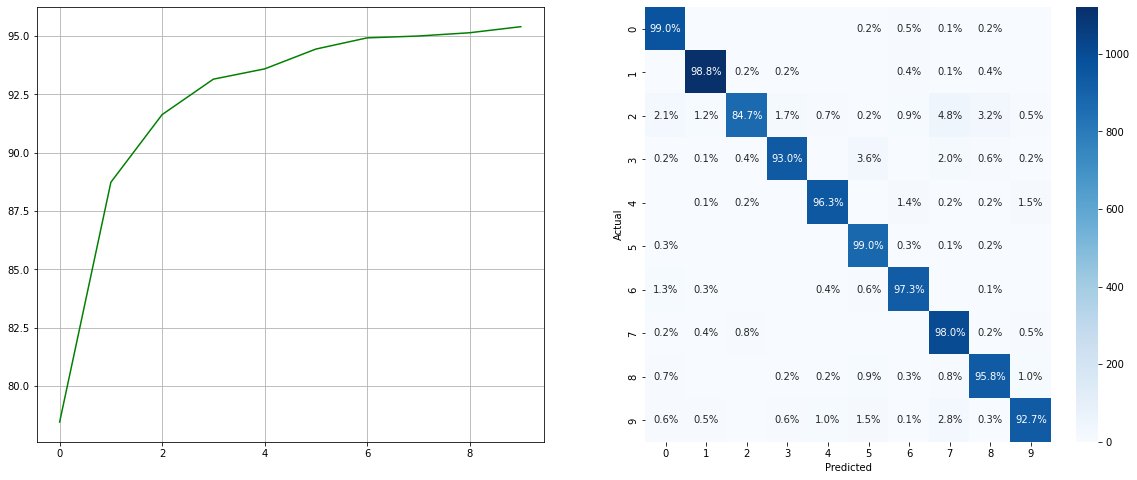

In [10]:
train_labels = trainset.y
train_images = trainset.X
test_labels = test_dataloader.dataset.y
test_images = test_dataloader.dataset.X
class_labels = range(10)
# create sample weight initialized to 1
samples_weights = np.ones(len(train_labels))
# define indexes of the samples
train_target_indexes = np.arange(0, 59999, 1, dtype=int)
# define model + optimizer + Triplet_loss
#model = ConvNet()
model = Net()
optimizer = optim.Adadelta(model.parameters(), lr=0.1)
criterion = nn.CrossEntropyLoss(reduction='sum')
test_accs, confusion_mtxes = [], []

for epoch in range(10):
        #training
        train_loader = torch.utils.data.DataLoader(trainset, batch_size=128,  num_workers=0)
        class_counter = np.zeros(10)
        f1_score_class = np.zeros(10)
        model.train()

        for batch_i, (data, _) in enumerate(train_loader):
              # retrieve images and labels from trainloader
              image = data[0].to('cpu')
              batch_truth = data[1].to('cpu')
              # calculate the loss
              optimizer.zero_grad()
              output = model(image)
              loss = criterion(output, batch_truth)/len(output)
              loss.backward()
              optimizer.step()
              # show training loss 
              if batch_i % 100 == 0:
                print('epoch: {} [{}/{} ({:.0f}%)]\t training loss: {:.6f}'.format(
                    epoch, batch_i, len(train_loader),
                    100. * batch_i / len(train_loader), loss.item()))

        # testing
        # set the model to the evaluation state
        model.eval()
        loss = 0
        success = 0
        correct = 0
        targets, preds = [], []
        with torch.no_grad():
            for data, indx in test_dataloader:
                X, y = data[0], data[1]
                # calculate the probalities 
                pred_prob = model(X)
                pred = pred_prob.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct += pred.eq(y.view_as(pred)).sum().item()
                targets += list(y.cpu().numpy())
                preds += list(pred.cpu().numpy())
    
                # loss summed across the batch
                loss += criterion(pred_prob, y).item()
                # use argmax to get the most likely prediction
                pred = pred_prob.argmax(dim=1, keepdim=True)  
                success += pred.eq(y.view_as(pred)).sum().item()
            test_acc = 100. * correct / len(test_dataloader.dataset)
            confusion_mtx = sm.confusion_matrix(targets, preds)
            test_accs.append(test_acc)
            confusion_mtxes.append(confusion_mtx)
            
        # calculate the loss
        loss /= len(test_dataloader.dataset)
        print('\rBest test acc = %2.2f%%' % max(test_accs))
        # calculate the accuracy
        accuracy = 100. * success / len(test_dataloader.dataset)

        # show the loss + accuracy
        print('\nTest dataset: Overall Loss: {:.4f}, Overall Accuracy: {}/{} ({:.0f}%)\n'.format(
            loss, success, len(test_dataloader.dataset), accuracy))

vis(test_accs, confusion_mtxes, class_labels)

In [11]:
from collections import Counter

class ClassLevelHardMining():
    def __init__(self,labels):
        super(ClassLevelHardMining, self).__init__()
        self.sample_counts = Counter(labels.tolist())
        self.omega = None  # Class imbalance measure
        self.minority_class = None
        self.minority_indices = None
        self.majority_class = None
        self.majority_indices = None

    def _make_omega(self, majority_class_label, minority_class_label):
        if self.omega is not None:
            return self.omega
        return (self.sample_counts[majority_class_label] - self.sample_counts[minority_class_label]) / (self.sample_counts[majority_class_label]+0.05)
        
    def on_batch_begin(self, last_target):
        targets = last_target.cpu()
        target_indices = set(enumerate(targets))
        label_count = Counter(targets.tolist())
        self.minority_class = min(label_count, key=label_count.get)  # Find the class with the least num of samples
        self.minority_indices = [i[0] for i in target_indices if i[1] == self.minority_class]
        self.majority_class = max(label_count, key=label_count.get)
        self.majority_indices = [i[0] for i in target_indices if i[1] == self.majority_class]
        self.omega = self._make_omega(self.majority_class, self.minority_class)

    def on_loss_begin(self, last_output):
        predictions = last_output.cpu()
        # Every minority sample is also treated as an anchor
        minority_predictions = anchors = predictions[self.minority_indices][:, self.minority_class]
        majority_predictions = predictions[self.majority_indices][:, self.majority_class]
        k = len(minority_predictions) if len(minority_predictions) < 25 else 25
        
        # take lowest k prediction scores for minority class: hard positive samples
        bottom_k_hard_pos = torch.sort(minority_predictions)[0][:k] 
        
        # take highest k prediction scores from the opposite class(viz majority class): hard negative samples
        top_k_hard_neg = torch.sort(majority_predictions, descending=True)[0][:k]
        return (anchors, bottom_k_hard_pos, top_k_hard_neg, predictions, self.omega)


##### Let's write our custom loss function named `ClassRectificationLoss`

In [12]:
class ClassRectificationLoss(nn.Module):
    def __init__(self, eta=0.01, margin=0.5):
        super(ClassRectificationLoss, self).__init__()
        self.eta = eta  # Subparameter of α
        self.margin = margin 
        
    def _relative_comparison(self, anchor, positive, negative):
        distance_positive = F.l1_loss(anchor, positive, reduction='sum')
        distance_negative = F.l1_loss(anchor, negative, reduction='sum')
        losses = F.relu(distance_positive - distance_negative + self.margin) # Triplet Loss
        return losses.mean()

    def forward(self, last_output, targets, reduction='none'):
        targets = targets.cpu()
        a, p, n, predictions, omega = last_output
        alpha = (self.eta * omega)
        return (alpha * self._relative_comparison(a, p, n)) + ((1 - alpha) * F.nll_loss(predictions, targets))


##### Let's initialize the model and implement the training loop utilizing our new loss function of ClassRectificationLoss and ClassLevelHardMining as a callback function.

# Class Rectification Loss

epoch: 0 [0/217 (0%)]	 training loss: 2.335267
epoch: 0 [100/217 (46%)]	 training loss: 1.192900
epoch: 0 [200/217 (92%)]	 training loss: 0.759436
Best test acc = 73.29%

Test dataset: Overall Loss: 0.7840, Overall Accuracy: 7328/9999 (73%)

epoch: 1 [0/217 (0%)]	 training loss: 0.669849
epoch: 1 [100/217 (46%)]	 training loss: 0.744590
epoch: 1 [200/217 (92%)]	 training loss: 0.383630
Best test acc = 84.41%

Test dataset: Overall Loss: 0.4865, Overall Accuracy: 8440/9999 (84%)

epoch: 2 [0/217 (0%)]	 training loss: 0.484760
epoch: 2 [100/217 (46%)]	 training loss: 0.551428
epoch: 2 [200/217 (92%)]	 training loss: 0.483592
Best test acc = 88.76%

Test dataset: Overall Loss: 0.3677, Overall Accuracy: 8875/9999 (89%)

epoch: 3 [0/217 (0%)]	 training loss: 0.414931
epoch: 3 [100/217 (46%)]	 training loss: 0.448927
epoch: 3 [200/217 (92%)]	 training loss: 0.345878
Best test acc = 91.13%

Test dataset: Overall Loss: 0.3015, Overall Accuracy: 9112/9999 (91%)

epoch: 4 [0/217 (0%)]	 training 

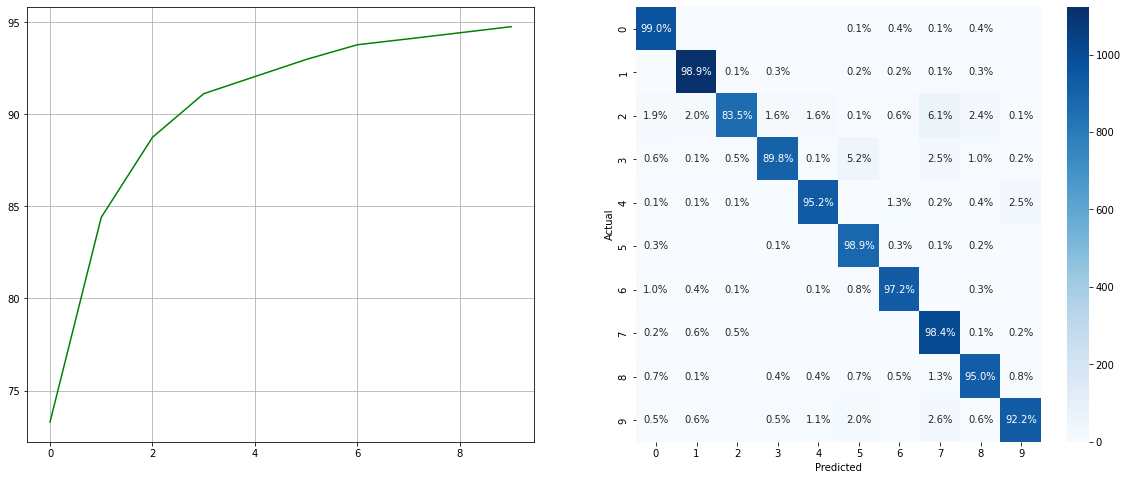

In [13]:
train_labels = trainset.y
train_images = trainset.X
test_labels = test_dataloader.dataset.y
test_images = test_dataloader.dataset.X
class_labels = range(10)
# create sample weight initialized to 1
samples_weights = np.ones(len(train_labels))
# define indexes of the samples
train_target_indexes = np.arange(0, 59999, 1, dtype=int)
# define model + optimizer + Triplet_loss
#model = ConvNet()
model = Net()
optimizer = optim.Adadelta(model.parameters(), lr=0.1)
rectificationloss = ClassRectificationLoss()
test_accs, confusion_mtxes = [], []

for epoch in range(10):
        #training
        train_loader = torch.utils.data.DataLoader(trainset, batch_size=128,  num_workers=0)
        class_counter = np.zeros(10)
        f1_score_class = np.zeros(10)
        model.train()

        for batch_i, (data, _) in enumerate(train_loader):
              # retrieve images and labels from trainloader
              image = data[0].to('cpu')
              batch_truth = data[1].to('cpu')
              # calculate the loss
              classhardmining = ClassLevelHardMining(batch_truth)
              classhardmining.on_batch_begin(batch_truth)
              optimizer.zero_grad()
              output = model(image)
              triplet_output = classhardmining.on_loss_begin(output)
              loss = rectificationloss(triplet_output, batch_truth)
              loss.backward()
              optimizer.step()
              # show training loss 
              if batch_i % 100 == 0:
                print('epoch: {} [{}/{} ({:.0f}%)]\t training loss: {:.6f}'.format(
                    epoch, batch_i, len(train_loader),
                    100. * batch_i / len(train_loader), loss.item()))

        # testing
        # set the model to the evaluation state
        model.eval()
        loss = 0
        success = 0
        correct = 0
        targets, preds = [], []
        with torch.no_grad():
            for data, indx in test_dataloader:
                X, y = data[0], data[1]
                # calculate the probalities 
                pred_prob = model(X)
                pred = pred_prob.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct += pred.eq(y.view_as(pred)).sum().item()
                targets += list(y.cpu().numpy())
                preds += list(pred.cpu().numpy())
    
                # loss summed across the batch
                loss += F.nll_loss(pred_prob, y, reduction='sum').item()
                # use argmax to get the most likely prediction
                pred = pred_prob.argmax(dim=1, keepdim=True)  
                success += pred.eq(y.view_as(pred)).sum().item()
            test_acc = 100. * correct / len(test_dataloader.dataset)
            confusion_mtx = sm.confusion_matrix(targets, preds)
            test_accs.append(test_acc)
            confusion_mtxes.append(confusion_mtx)
            print('\rBest test acc = %2.2f%%' % max(test_accs))
        # calculate the loss
        loss /= len(test_dataloader.dataset)

        # calculate the accuracy
        accuracy = 100. * success / len(test_dataloader.dataset)

        # show the loss + accuracy
        print('\nTest dataset: Overall Loss: {:.4f}, Overall Accuracy: {}/{} ({:.0f}%)\n'.format(
            loss, success, len(test_dataloader.dataset), accuracy))

vis(test_accs, confusion_mtxes, class_labels)